In [3]:
# code to create boxplots
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# All trends

### Data import


it is warming everywhere -> but magnitude changes
-> influence of clear sky pixels ? verify with ERA5 land and satellite cloud cover !

In [4]:
trends_noaa_all = xr.open_dataset('significant_trends_1981_2007.nc')

In [5]:
trends_noaa_all

<xarray.Dataset>
Dimensions:                        (lat: 340, lon: 360)
Coordinates:
  * lat                            (lat) float32 55.03 55.08 ... 71.93 71.97
  * lon                            (lon) float32 -168.0 -167.9 ... -150.1 -150.0
Data variables:
    __xarray_dataarray_variable__  (lat, lon) float64 ...

In [6]:
trends_noaa_all['trends'] = trends_noaa_all['__xarray_dataarray_variable__'] *10

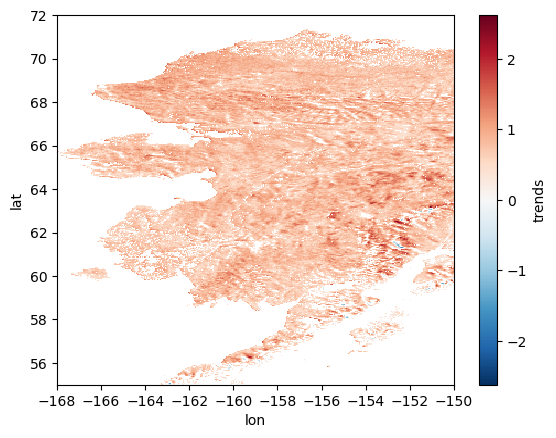

In [7]:
trends_noaa_all['trends'].plot();

In [8]:
wetness = xr.open_dataset('../alaska_wt_gradients.nc')

In [9]:
wetness

<xarray.Dataset>
Dimensions:      (x: 3281, y: 1955, band: 1)
Coordinates:
  * x            (x) float64 -171.3 -171.3 -171.3 ... -142.0 -142.0 -142.0
  * y            (y) float64 72.79 72.78 72.77 72.76 ... 55.35 55.34 55.33 55.33
  * band         (band) int64 1
Data variables:
    spatial_ref  int64 ...
    band_data    (band, y, x) float32 ...

In [10]:
# load landcover and anette's landcover! (first normal landcover)
land_cover = xr.open_dataset('/mnt/data7/nfs4/avh_ndvi/sdupuis/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7b.nc', engine='netcdf4')

In [11]:
lc = land_cover.sel(lat=slice(72,55), lon=slice(-168,-150))

In [12]:
lc_interp = lc.interp(lat=trends_noaa_all.coords['lat'], lon=trends_noaa_all.coords['lon'], method='nearest')

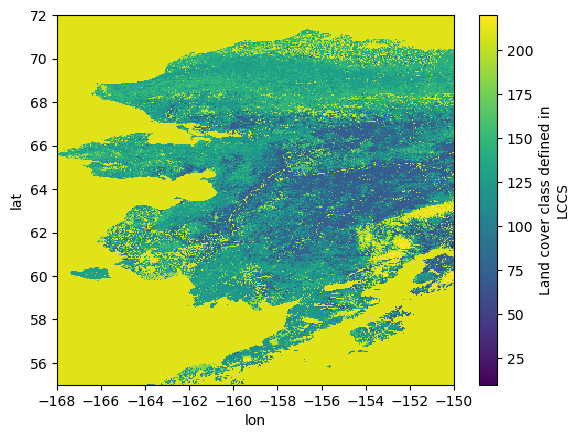

In [13]:
lc_interp['lccs_class'].plot();

In [14]:
wetness_interp = wetness['band_data'].interp(y=trends_noaa_all.coords['lat'], x=trends_noaa_all.coords['lon'], method='nearest').squeeze()

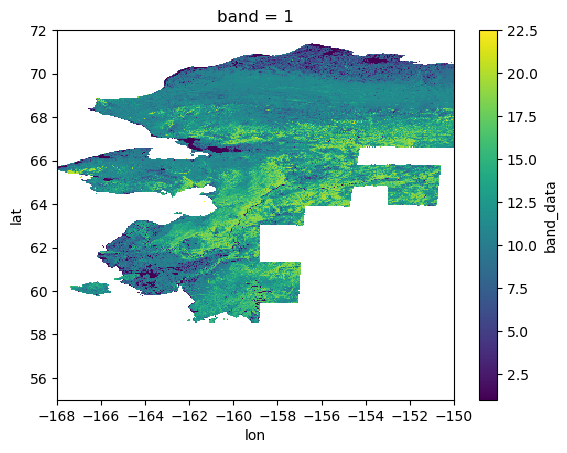

In [15]:
wetness_interp.plot();

In [16]:
trend_w = trends_noaa_all.where(~np.isnan(wetness_interp))
wet = wetness_interp.where(~np.isnan(trends_noaa_all['__xarray_dataarray_variable__'])).squeeze()

In [17]:
trend = trends_noaa_all.where(~np.isnan(lc_interp['lccs_class']))
landcover = lc_interp.where(~np.isnan(trends_noaa_all['__xarray_dataarray_variable__']))

In [18]:
landcover

<xarray.Dataset>
Dimensions:              (lat: 340, lon: 360)
Coordinates:
  * lat                  (lat) float32 55.03 55.08 55.12 ... 71.88 71.93 71.97
  * lon                  (lon) float32 -168.0 -167.9 -167.9 ... -150.1 -150.0
Data variables:
    lccs_class           (lat, lon) float32 nan nan nan nan ... nan nan nan nan
    processed_flag       (lat, lon) float32 nan nan nan nan ... nan nan nan nan
    current_pixel_state  (lat, lon) float32 nan nan nan nan ... nan nan nan nan
    observation_count    (lat, lon) float32 nan nan nan nan ... nan nan nan nan
    change_count         (lat, lon) float32 nan nan nan nan ... nan nan nan nan
    crs                  (lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes: (12/38)
    title:                      ESA CCI Land Cover Map
    summary:                    This dataset contains the global ESA CCI land...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180.0
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

In [110]:
trend_1d = trend['trends'].stack(points=("lat", "lon"))
lc_1d = landcover['lccs_class'].stack(points=("lat", "lon"))

In [111]:
trend_1d_w = trend_w['trends'].stack(points=("lat", "lon"))
lc_1d_w = wet.stack(points=("lat", "lon"))

In [21]:
valid = (~np.isnan(trend_1d_w)) & (~np.isnan(lc_1d_w))
trend_1d_w = trend_1d_w[valid]
lc_1d_w = lc_1d_w[valid]

In [112]:
valid = (~np.isnan(trend_1d)) & (~np.isnan(lc_1d))
trend_1d = trend_1d[valid]
lc_1d = lc_1d[valid]

In [23]:
df_2 = pd.DataFrame({
    "trend": trend_1d_w.values,
    "landcover": lc_1d_w.values.astype(int)
})

In [63]:
# filter classes with very low samples
counts = df_2["landcover"].value_counts()
valid_classes = counts[counts > 10].index

df_2 = df_2[df_2["landcover"].isin(valid_classes)]

In [113]:
counts

landcover_group
Shrubland         5635
Grassland         4479
Sparse            2810
NEV               2216
Mixed Forest      1603
Lichens            825
Wetland            768
Bare               715
BD                 386
Flooded forest     248
ND                 190
Ice                162
Cropland             2
Name: count, dtype: int64

In [114]:
df = pd.DataFrame({
    "trend": trend_1d.values,
    "landcover": lc_1d.values.astype(int)
})


In [27]:
lc_wetness_map = {
    
    1: "water",
    2: "wetland",
    3: "wetland",
    4: "wetland",

    # 2. Forest
    5: "Graminoids",
    6: "Lichens/moss",
    7: "Lichens/moss",
    8: "low shrub",
    9: "low shrub",
    10:"low shrub",
    11:"low shrub",
    12:"low shrub",

    13: "low shrub",
    14: "low shrub",

    15: "low shrub",

    16: "low shrub",

    17: "low shrub",
    18: "Forest",
    19: "Forest",
    20: "Forest",
    21: "Barren",
    22: "Snow",
    23: "Other"
}

In [28]:
lc_group_map = {
    # 1. Agriculture
    10: "Cropland",
    20: "Cropland",
    30: "Cropland",
    40: "Cropland",

    # 2. Forest
    50: "BEV",
    60: "BD", 61: "BD", 62: "BD",
    70: "NEV", 71: "NEV", 72: "NEV",
    80: "ND", 81: "ND", 82: "ND",
    90: "Mixed Forest",
    100: "Mixed Forest",
    160: "Flooded forest",
    170: "Flooded forest",

    # 3. Grassland
    110: "Grassland",
    130: "Grassland",

    # 4. Wetland
    180: "Wetland",

    # 5. Settlement
    190: "Settlement",

    # 6. Other (Shrubland / Sparse / Bare / Water)
    120: "Shrubland",
    121: "Shrubland",
    122: "Shrubland",
    140: "Lichens",
    150: "Sparse",
    151: "Sparse",
    152: "Sparse",
    153: "Sparse",
    200: "Bare",
    201: "Bare",
    202: "Bare",
    220: "Ice"
}


In [115]:
df["landcover_group"] = df["landcover"].map(lc_group_map)

In [116]:
df

,trend,landcover,landcover_group
0,0.619089,120,Shrubland
1,0.660900,120,Shrubland
2,-0.484706,200,Bare
3,0.322026,120,Shrubland
4,0.368594,120,Shrubland
...,...,...,...
62045,0.741107,140,Lichens
62046,0.543709,140,Lichens
62047,0.408276,140,Lichens
62048,0.735362,140,Lichens


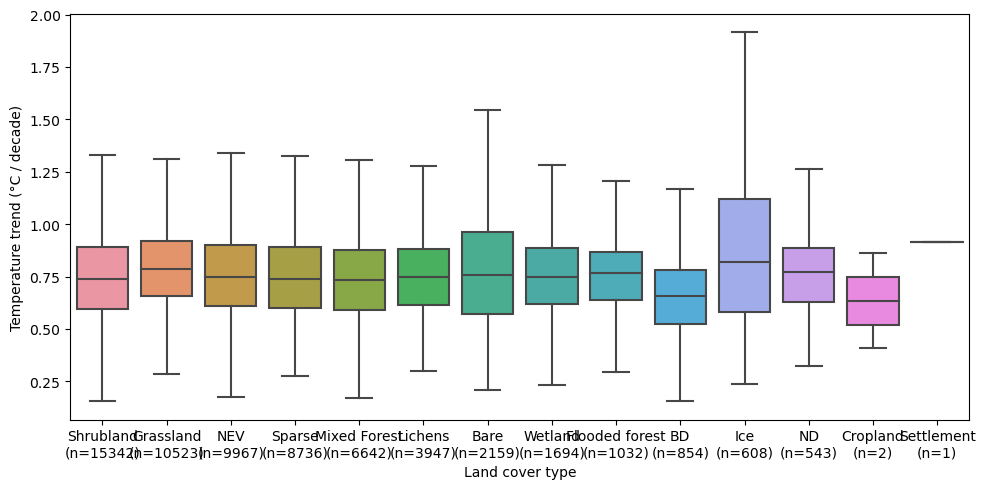

In [117]:
# Count samples per class
counts = df["landcover_group"].value_counts()

# Order classes by appearance or median
order = counts.index

plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    data=df,
    x="landcover_group",
    y="trend",
    order=order,
    showfliers=False
)

# Update x-tick labels to include counts
new_labels = [
    f"{label}\n(n={counts[label]})"
    for label in order
]

ax.set_xticklabels(new_labels)

ax.set_xlabel("Land cover type")
ax.set_ylabel("Temperature trend (°C / decade)")
plt.tight_layout()
plt.show()


In [118]:
# filter classes with very low samples
counts = df["landcover_group"].value_counts()
valid_classes = counts[counts > 20].index

df = df[df["landcover_group"].isin(valid_classes)]


In [119]:
counts

landcover_group
Shrubland         15342
Grassland         10523
NEV                9967
Sparse             8736
Mixed Forest       6642
Lichens            3947
Bare               2159
Wetland            1694
Flooded forest     1032
BD                  854
Ice                 608
ND                  543
Cropland              2
Settlement            1
Name: count, dtype: int64

### results all noaa

In [120]:
df

,trend,landcover,landcover_group
0,0.619089,120,Shrubland
1,0.660900,120,Shrubland
2,-0.484706,200,Bare
3,0.322026,120,Shrubland
4,0.368594,120,Shrubland
...,...,...,...
62045,0.741107,140,Lichens
62046,0.543709,140,Lichens
62047,0.408276,140,Lichens
62048,0.735362,140,Lichens


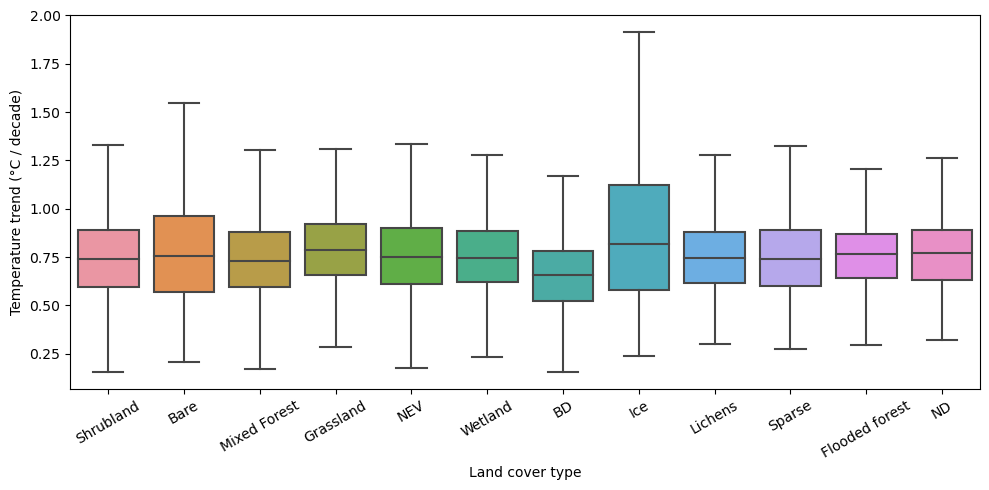

In [121]:
# merge the classes ! 

plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df,
    x="landcover_group",   # or "landcover"
    y="trend",
    showfliers=False
)

plt.ylabel("Temperature trend (°C / decade)")
plt.xlabel("Land cover type")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# 220: permanent snow and ice, 200: bare areas, 180: shrub or herbaceous cover, 160: tree cover, flooded, fresh or brackish water, 152: sparse vegetation, 150:sparse vegetation,
# 140 : liches and moss, 130, grasssland, 120: shrubland, 100: mosaic tree nad shrubs, 90: tree cover, mixed leaves, 80, tree cover decidious, needlleaved, 70, needleaved, evegergren,
# 61 : borad leave deciduous

In [36]:
df_2["landcover_group"] = df_2["landcover"].map(lc_wetness_map)

In [37]:
df_2

,trend,landcover,landcover_group
0,0.835443,9,low shrub
1,0.955506,14,low shrub
2,0.801138,15,low shrub
3,0.468060,15,low shrub
4,0.988522,7,Lichens/moss
...,...,...,...
44566,0.741107,7,Lichens/moss
44567,0.543709,7,Lichens/moss
44568,0.408276,4,wetland
44569,0.735362,7,Lichens/moss


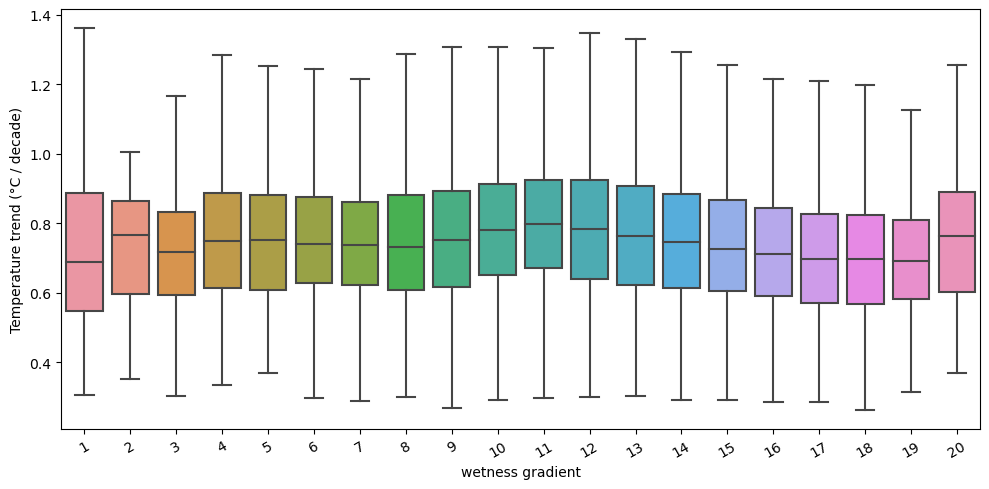

In [65]:
# verify legends
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_2,
    x="landcover",   # or "landcover"
    y="trend",
    showfliers=False
)

plt.ylabel("Temperature trend (°C / decade)")
plt.xlabel("wetness gradient")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# check box plots from Sina -> verify with air temperature !!! -> check "AWI stations"
# 3 wetland, permanent, 4 wet wet to aquatic tundra (seasonal), abundant moss, 5 Moist to wet tundra, abundant moss, prostrate shrubs, 6 dry to moist tundra, partially barren, prostrate shrubs
# 7 dry tundra, abundant lichen, prostrate shrubs, 8 dry to aquatic tundra, dwarf shrubs (& sparse tree cover along treeline), 9 dry to moist tundra, prostrate to low shrubs
# 10 moist tundra, abundant moss, prostrate to low shrubs, 11 moist tundra, abundant moss, dwarf and low shrubs
# different grouping !

### NOAA 1981-2001

In [66]:
trends_noaa_1981_2001 = xr.open_dataset('significant_trends_noaa_1981_2001.nc')

In [67]:
trends_noaa_1981_2001['trends'] = trends_noaa_1981_2001['__xarray_dataarray_variable__'] *10

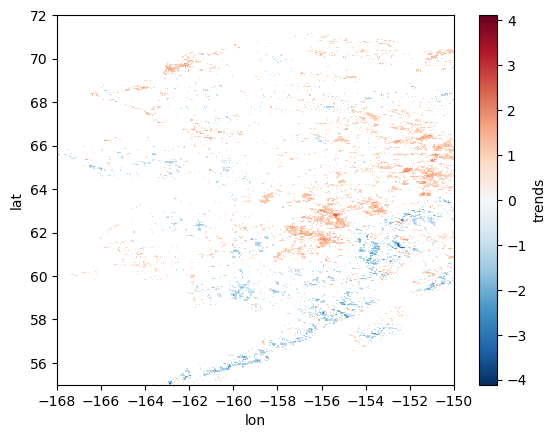

In [69]:
trends_noaa_1981_2001['trends'].plot();

In [70]:
trend_2 = trends_noaa_1981_2001.where(~np.isnan(lc_interp['lccs_class']))
landcover_2 = lc_interp.where(~np.isnan(trends_noaa_1981_2001['__xarray_dataarray_variable__']))

In [71]:
trend_1d_2 = trend_2['trends'].stack(points=("lat", "lon"))
lc_1d_2 = landcover_2['lccs_class'].stack(points=("lat", "lon"))

In [72]:
valid_2 = (~np.isnan(trend_1d_2)) & (~np.isnan(lc_1d_2))
trend_1d_2 = trend_1d_2[valid_2]
lc_1d_2 = lc_1d_2[valid_2]

In [73]:
df_1981 = pd.DataFrame({
    "trend": trend_1d_2.values,
    "landcover": lc_1d_2.values.astype(int)
})

In [74]:
df_1981["landcover_group"] = df_1981["landcover"].map(lc_group_map)

In [75]:
df_1981

,trend,landcover,landcover_group
0,-0.695376,120,Shrubland
1,-0.771979,180,Wetland
2,0.722384,120,Shrubland
3,-1.328981,200,Bare
4,-3.399282,200,Bare
...,...,...,...
8862,1.026172,140,Lichens
8863,1.195034,180,Wetland
8864,1.072787,140,Lichens
8865,0.933159,140,Lichens


In [77]:
# filter classes with very low samples
counts = df_1981["landcover_group"].value_counts()
valid_classes = counts[counts > 20].index

df_1981 = df_1981[df_1981["landcover_group"].isin(valid_classes)]


In [78]:
counts

landcover_group
Shrubland         2175
NEV               1958
Mixed Forest      1220
Sparse             857
Grassland          726
Bare               672
Lichens            445
Wetland            272
Ice                232
BD                 135
Flooded forest     129
ND                  45
Settlement           1
Name: count, dtype: int64

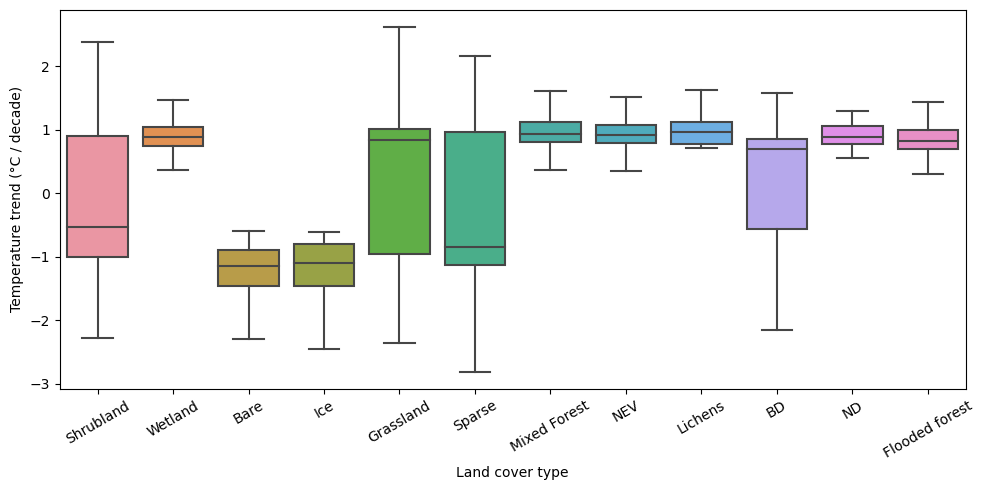

In [79]:
# merge the classes ! 

plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_1981,
    x="landcover_group",   # or "landcover"
    y="trend",
    showfliers=False
)

plt.ylabel("Temperature trend (°C / decade)")
plt.xlabel("Land cover type")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# 220: permanent snow and ice, 200: bare areas, 180: shrub or herbaceous cover, 160: tree cover, flooded, fresh or brackish water, 152: sparse vegetation, 150:sparse vegetation,
# 140 : liches and moss, 130, grasssland, 120: shrubland, 100: mosaic tree nad shrubs, 90: tree cover, mixed leaves, 80, tree cover decidious, needlleaved, 70, needleaved, evegergren,
# 61 : borad leave deciduous

In [80]:
trends_noaa_2001_2018 = xr.open_dataset('significant_trends_noaa_2001_2018.nc')

In [81]:
trends_noaa_2001_2018['trends'] = trends_noaa_2001_2018['__xarray_dataarray_variable__'] *10

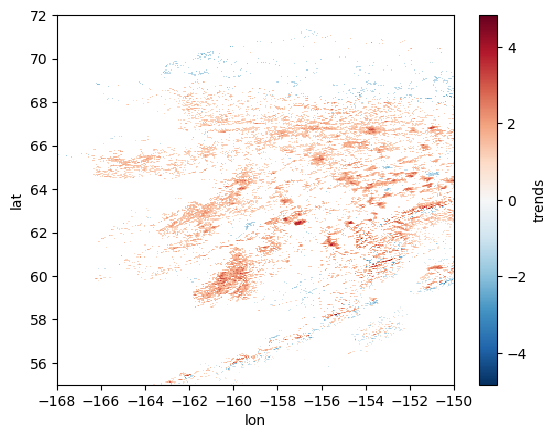

In [82]:
trends_noaa_2001_2018['trends'].plot();

In [83]:
trend_3 = trends_noaa_2001_2018.where(~np.isnan(lc_interp['lccs_class']))
landcover_3 = lc_interp.where(~np.isnan(trends_noaa_2001_2018['__xarray_dataarray_variable__']))

In [84]:
trend_1d_3 = trend_3['trends'].stack(points=("lat", "lon"))
lc_1d_3 = landcover_3['lccs_class'].stack(points=("lat", "lon"))

In [85]:
valid_3 = (~np.isnan(trend_1d_3)) & (~np.isnan(lc_1d_3))
trend_1d_3 = trend_1d_3[valid_3]
lc_1d_3 = lc_1d_3[valid_3]

In [86]:
df_2001 = pd.DataFrame({
    "trend": trend_1d_3.values,
    "landcover": lc_1d_3.values.astype(int)
})

In [87]:
df_2001["landcover_group"] = df_2001["landcover"].map(lc_group_map)

In [89]:
# filter classes with very low samples
counts = df_2001["landcover_group"].value_counts()
valid_classes = counts[counts > 20].index

df_2001 = df_2001[df_2001["landcover_group"].isin(valid_classes)]

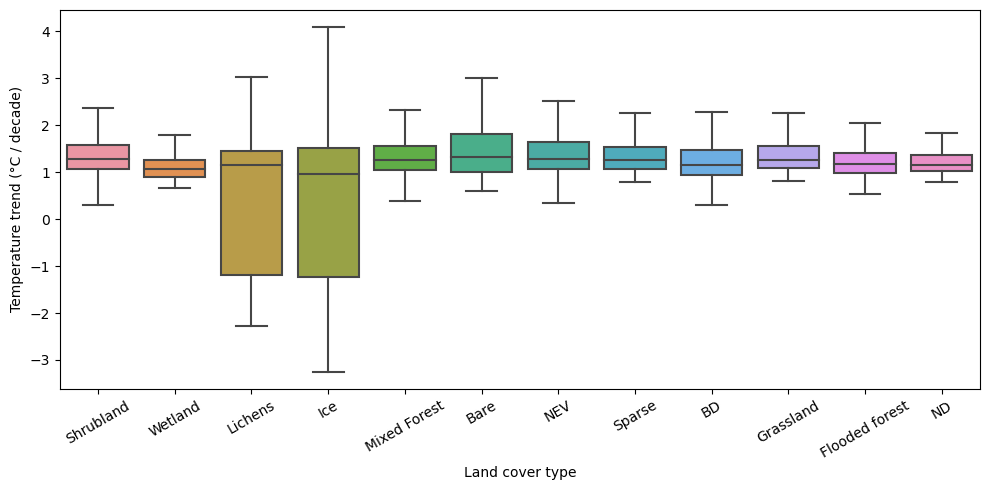

In [90]:
# merge the classes ! 

plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_2001,
    x="landcover_group",   # or "landcover"
    y="trend",
    showfliers=False
)

plt.ylabel("Temperature trend (°C / decade)")
plt.xlabel("Land cover type")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Where are those lichens ? plot it ? 

In [91]:
# Do metop plots ! 

trends_metop = xr.open_dataset('significant_trends_metop.nc')


In [96]:
trends_metop['trends'] = trends_metop['__xarray_dataarray_variable__'] *10

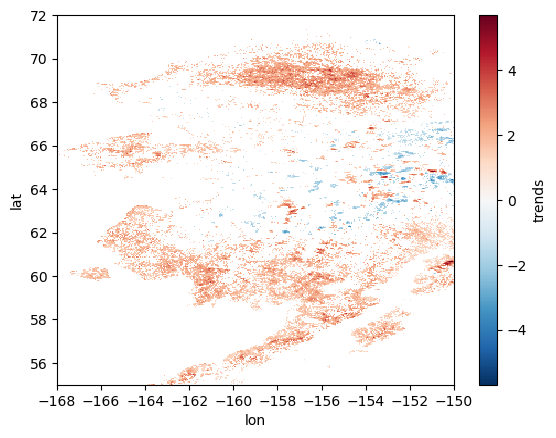

In [97]:
trends_metop['trends'].plot();

In [98]:
trend_4 = trends_metop.where(~np.isnan(lc_interp['lccs_class']))
landcover_4 = lc_interp.where(~np.isnan(trends_metop['__xarray_dataarray_variable__']))

In [100]:
trend_1d_4 = trend_4['trends'].stack(points=("lat", "lon"))
lc_1d_4 = landcover_4['lccs_class'].stack(points=("lat", "lon"))
valid_4 = (~np.isnan(trend_1d_4)) & (~np.isnan(lc_1d_4))
trend_1d_4 = trend_1d_4[valid_4]
lc_1d_4 = lc_1d_4[valid_4]

In [101]:
df_metop = pd.DataFrame({
    "trend": trend_1d_4.values,
    "landcover": lc_1d_4.values.astype(int)
})

In [102]:
df_metop["landcover_group"] = df_metop["landcover"].map(lc_group_map)

In [103]:
# filter classes with very low samples
counts = df_metop["landcover_group"].value_counts()
valid_classes = counts[counts > 20].index

df_metop = df_metop[df_metop["landcover_group"].isin(valid_classes)]

In [105]:
counts

landcover_group
Shrubland         5635
Grassland         4479
Sparse            2810
NEV               2216
Mixed Forest      1603
Lichens            825
Wetland            768
Bare               715
BD                 386
Flooded forest     248
ND                 190
Ice                162
Cropland             2
Name: count, dtype: int64

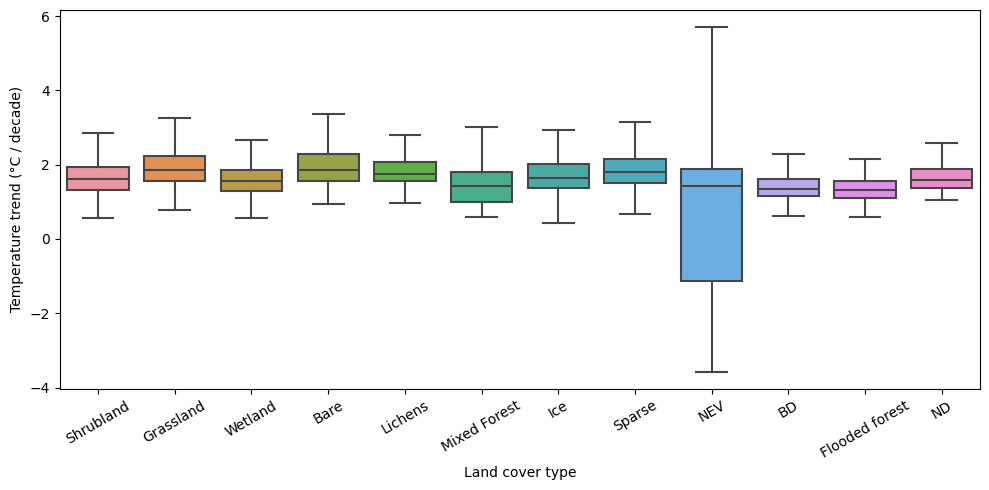

In [104]:
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_metop,
    x="landcover_group",   # or "landcover"
    y="trend",
    showfliers=False
)

plt.ylabel("Temperature trend (°C / decade)")
plt.xlabel("Land cover type")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [130]:
result = (
    pd.concat(
        [df, df_1981, df_2001, df_metop],
        keys=["NOAA-1981-2018", "NOAA-1981-2001", "NOAA-2001-2018", "Metop-2007-2023"],
        names=["key"]
    )
    .reset_index(level="key")
)

In [131]:
result

,key,trend,landcover,landcover_group
0,NOAA-1981-2018,0.619089,120,Shrubland
1,NOAA-1981-2018,0.660900,120,Shrubland
2,NOAA-1981-2018,-0.484706,200,Bare
3,NOAA-1981-2018,0.322026,120,Shrubland
4,NOAA-1981-2018,0.368594,120,Shrubland
...,...,...,...,...
20036,Metop-2007-2023,1.699982,140,Lichens
20037,Metop-2007-2023,1.886265,140,Lichens
20038,Metop-2007-2023,1.238376,180,Wetland
20039,Metop-2007-2023,1.265392,150,Sparse


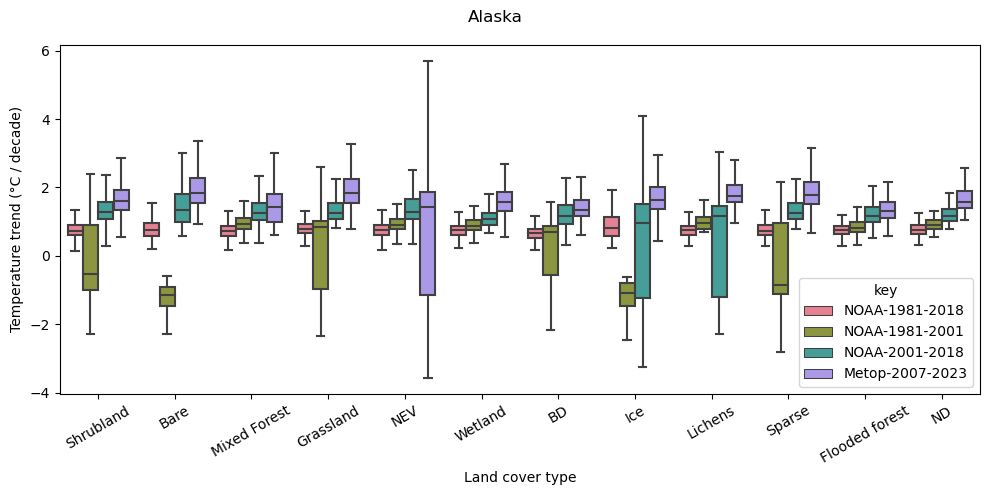

In [132]:
# Group all boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=result,
    x="landcover_group",   # or "landcover"
    y="trend",
    hue='key',
    palette = 'husl',
    showfliers=False
)

plt.ylabel("Temperature trend (°C / decade)")
plt.xlabel("Land cover type")
plt.suptitle('Alaska')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('Alaska_box_plot.png')
plt.show()

In [ ]:
# count clear sky observations ! and compare to ERA5 land -> cloud cover !

In [ ]:
# stack all 3 box plots on top of each other! 

In [133]:
# verify correlation to elevation
dem = xr.open_dataset('/mnt/data7/nfs4/avh_lst/sdupuis/auxiliary/DEM_global_SRTMV41_TDMX_llwgs84_avg_005deg_nodata.tif')

In [134]:
dem

<xarray.Dataset>
Dimensions:      (band: 1, x: 7200, y: 3600)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * y            (y) float64 89.97 89.92 89.88 89.82 ... -89.88 -89.93 -89.98
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float64 ...

In [136]:
dem_interp = dem['band_data'].interp(y=trends_noaa_all.coords['lat'], x=trends_noaa_all.coords['lon'], method='linear').squeeze()

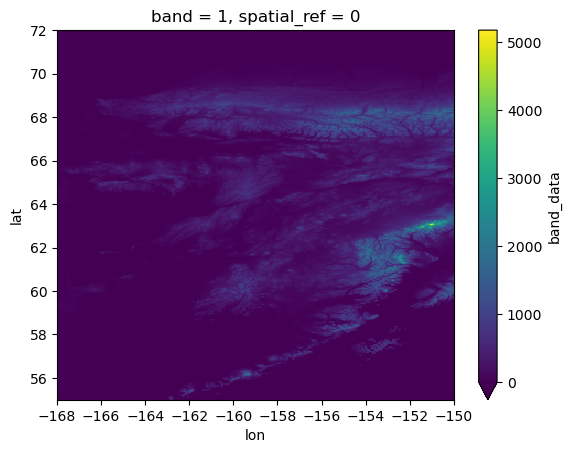

In [144]:
dem_interp.plot(vmin=0);

In [139]:
trend_1d = trend['trends'].stack(points=("lat", "lon"))
dem_1d = dem_interp.stack(points=("lat", "lon"))

mask = (
    ~np.isnan(trend_1d) &
    ~np.isnan(dem_1d)
)

trend_1d = trend_1d[mask]
dem_1d = dem_1d[mask]

In [140]:
x = dem_1d.to_numpy()
y = trend_1d.to_numpy()

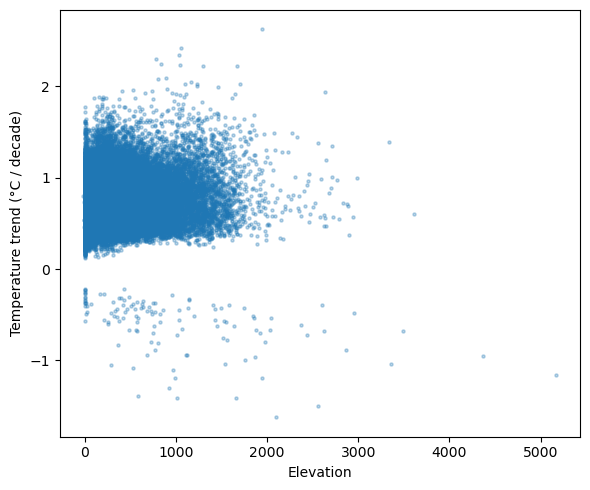

In [146]:
plt.figure(figsize=(6, 5))
plt.scatter(x, y, s=5, alpha=0.3)

plt.xlabel("Elevation")
plt.ylabel("Temperature trend (°C / decade)")
plt.tight_layout()
plt.show()

In [154]:
# do bins for elevation
bins_dem = np.arange(0, 4400, 400)
bin_labels_dem = [f"{bins_dem[i]}–{bins_dem[i+1]}" for i in range(len(bins_dem)-1)]

In [155]:

df_bin = pd.DataFrame({
    "trend": y,
    "dem_len": x
})

df_bin["dem_bin"] = pd.cut(
    df_bin["dem_len"],
    bins=bins_dem,
    labels=bin_labels_dem,
    include_lowest=True
)
df_bin = df_bin.dropna(subset=["dem_bin"])

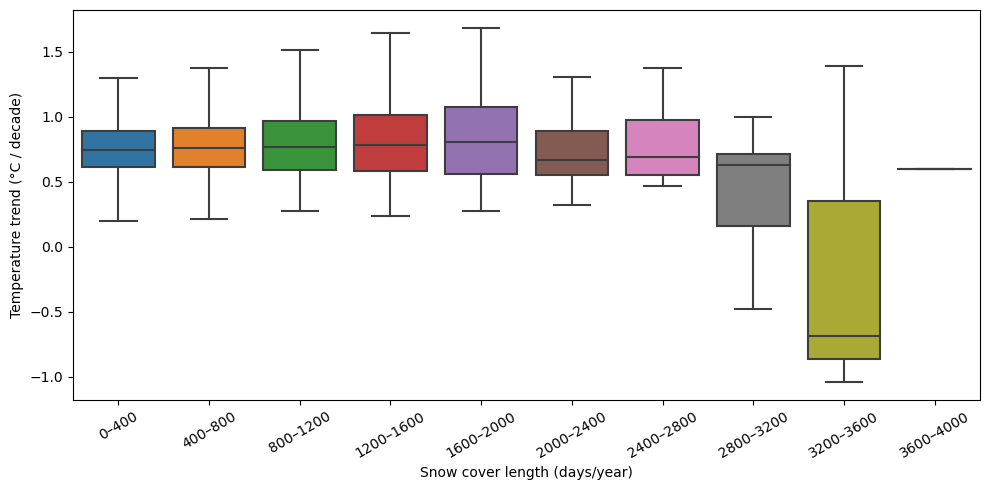

In [156]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    data=df_bin,
    x="dem_bin",
    y="trend",
    showfliers=False
)

plt.xlabel("Snow cover length (days/year)")
plt.ylabel("Temperature trend (°C / decade)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
# trends per decade in relation to warming trends

In [ ]:
# verify correlation to march SWE

In [ ]:
# evergreen needleleaves! 

### Arclim

In [40]:
# recompute trends for snow cover onset -> or mean values ? yes mean values !
# satellite product ? do like for emissivity ? trends of snow cover ??? -> something more simple ! -> trends need to be recomputed!

arclim = xr.open_dataset('../arclim_means.nc')

In [41]:
arclim

<xarray.Dataset>
Dimensions:    (longitude: 3600, latitude: 451)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... 45.3 45.2 45.1 45.0
Data variables: (12/18)
    GSL        (latitude, longitude) float64 ...
    GDD        (latitude, longitude) float64 ...
    FGS        (latitude, longitude) float64 ...
    FDD        (latitude, longitude) float64 ...
    ROS        (latitude, longitude) float64 ...
    WWE        (latitude, longitude) float64 ...
    ...         ...
    SSE        (latitude, longitude) float64 ...
    HWE        (latitude, longitude) float64 ...
    TAVG       (latitude, longitude) float64 ...
    PRA        (latitude, longitude) float64 ...
    SFA        (latitude, longitude) float64 ...
    WSA        (latitude, longitude) float64 ...
Attributes:
    title:        ARCLIM Bioclimatic indices
    Institution:  Finnish Meteorological Institute
    source:       ERA5-Land
    history:      2022-12-08 12:43:13 Python

In [42]:
# get the trends ?

arclim_trends = xr.open_dataset('../arclim_trends.tif')

In [43]:
arclim_trends

<xarray.Dataset>
Dimensions:      (band: 18, x: 3600, y: 451)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * y            (y) float64 90.0 89.9 89.8 89.7 89.6 ... 45.3 45.2 45.1 45.0
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float64 ...

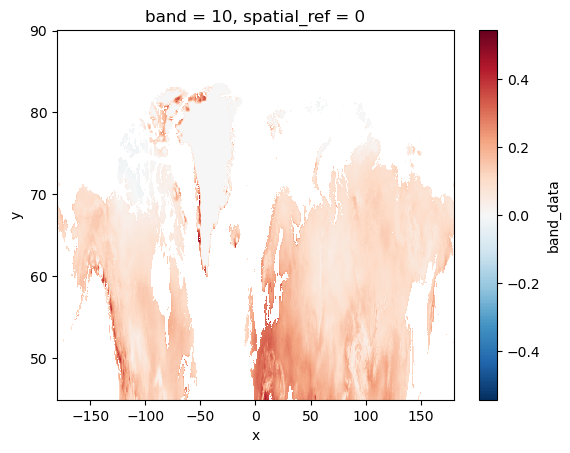

In [44]:
arclim_trends['band_data'].isel(band=9).plot();

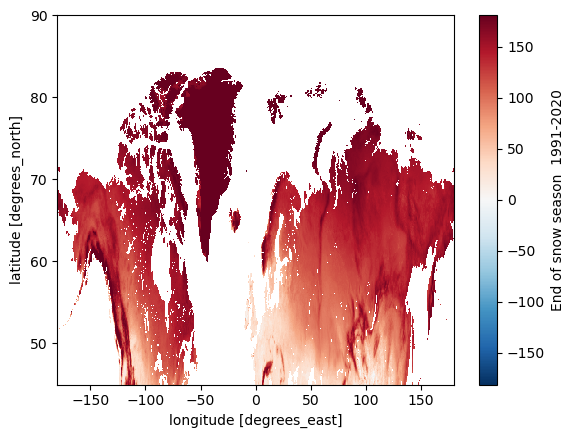

In [45]:
arclim['SSE'].plot();

In [46]:
snow_cover_mean = arclim['SSL']

In [47]:
ssl_interp = snow_cover_mean.interp(latitude=trends_noaa_all.coords['lat'], longitude=trends_noaa_all.coords['lon'], method='linear').squeeze()

In [48]:
ssl_interp

<xarray.DataArray 'SSL' (lat: 340, lon: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    latitude   (lat) float32 55.03 55.08 55.12 55.17 ... 71.82 71.88 71.93 71.97
    longitude  (lon) float32 -168.0 -167.9 -167.9 ... -150.1 -150.1 -150.0
  * lat        (lat) float32 55.03 55.08 55.12 55.17 ... 71.82 71.88 71.93 71.97
  * lon        (lon) float32 -168.0 -167.9 -167.9 ... -150.1 -150.1 -150.0
Attributes:
    long_name:   Snow season length 1991-2020
    short_name:  SSL

In [49]:
land_cover

<xarray.Dataset>
Dimensions:              (lat: 64800, lon: 129600)
Coordinates:
  * lat                  (lat) float32 90.0 90.0 89.99 ... -89.99 -90.0 -90.0
  * lon                  (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0
Data variables:
    lccs_class           (lat, lon) float32 ...
    processed_flag       (lat, lon) float32 ...
    current_pixel_state  (lat, lon) float32 ...
    observation_count    (lat, lon) float32 ...
    change_count         (lat, lon) float32 ...
    crs                  int32 ...
Attributes: (12/38)
    title:                      ESA CCI Land Cover Map
    summary:                    This dataset contains the global ESA CCI land...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180.0
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

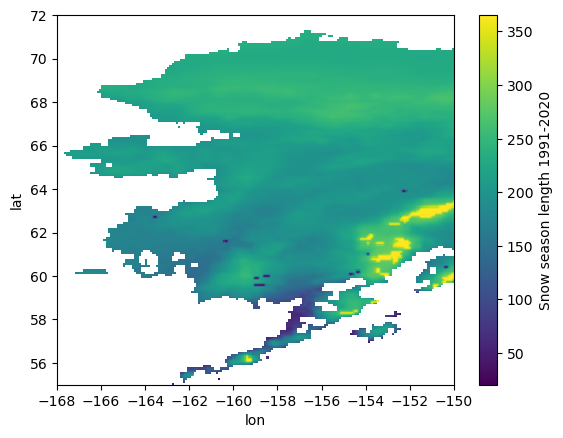

In [50]:
ssl_interp.plot();

In [157]:
trend_1d = trend['trends'].stack(points=("lat", "lon"))
snow_1d = ssl_interp.stack(points=("lat", "lon"))

mask = (
    ~np.isnan(trend_1d) &
    ~np.isnan(snow_1d)
)

trend_1d = trend_1d[mask]
snow_1d = snow_1d[mask]


In [158]:
x = snow_1d.to_numpy()
y = trend_1d.to_numpy()


Slope: 0.001, Intercept: 0.512, R²: 0.034


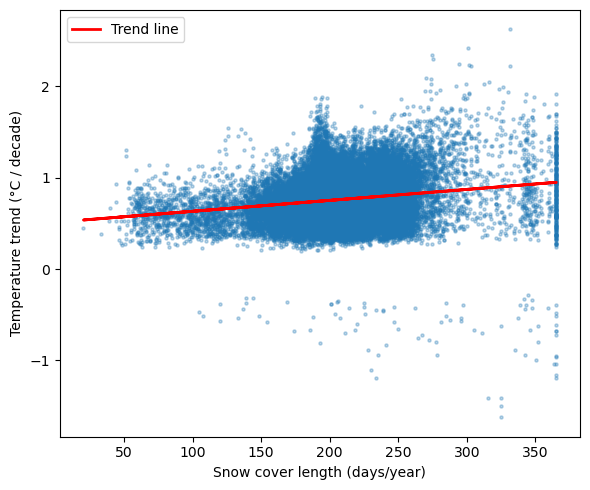

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Example data
# x = snow cover length
# y = temperature trend

# Compute linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print(f"Slope: {slope:.3f}, Intercept: {intercept:.3f}, R²: {r_value**2:.3f}")

# Plot scatter
plt.figure(figsize=(6, 5))
plt.scatter(x, y, s=5, alpha=0.3)

# Plot trend line
plt.plot(x, slope*x + intercept, color='red', linewidth=2, label='Trend line')

plt.xlabel("Snow cover length (days/year)")
plt.ylabel("Temperature trend (°C / decade)")
plt.legend()
plt.tight_layout()
plt.show()


In [161]:
from sklearn.linear_model import TheilSenRegressor

model = TheilSenRegressor()
model.fit(x, y)
y_pred = model.predict(x)

plt.figure(figsize=(6,5))
plt.scatter(x, y, s=5, alpha=0.3)
plt.plot(x, y_pred, color='green', linewidth=2, label='Robust trend (Theil-Sen)')
plt.xlabel("Snow cover length (days/year)")
plt.ylabel("Temperature trend (°C / decade)")
plt.legend()
plt.tight_layout()
plt.show()


ValueError: Expected 2D array, got 1D array instead:
array=[ 46.11268279  53.00418925  91.37583952 ... 236.85832825 236.92500509
 236.9333257 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

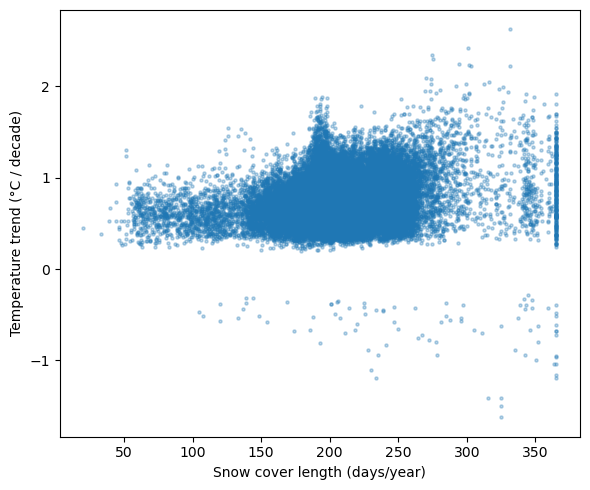

In [159]:
plt.figure(figsize=(6, 5))
plt.scatter(x, y, s=5, alpha=0.3)

plt.xlabel("Snow cover length (days/year)")
plt.ylabel("Temperature trend (°C / decade)")
plt.tight_layout()
plt.show()

In [54]:

bins = np.arange(0, 366, 30)
bin_labels = [f"{bins[i]}–{bins[i+1]}" for i in range(len(bins)-1)]


In [55]:

df_bin = pd.DataFrame({
    "trend": y,
    "snow_len": x
})

df_bin["snow_bin"] = pd.cut(
    df_bin["snow_len"],
    bins=bins,
    labels=bin_labels,
    include_lowest=True
)
df_bin = df_bin.dropna(subset=["snow_bin"])


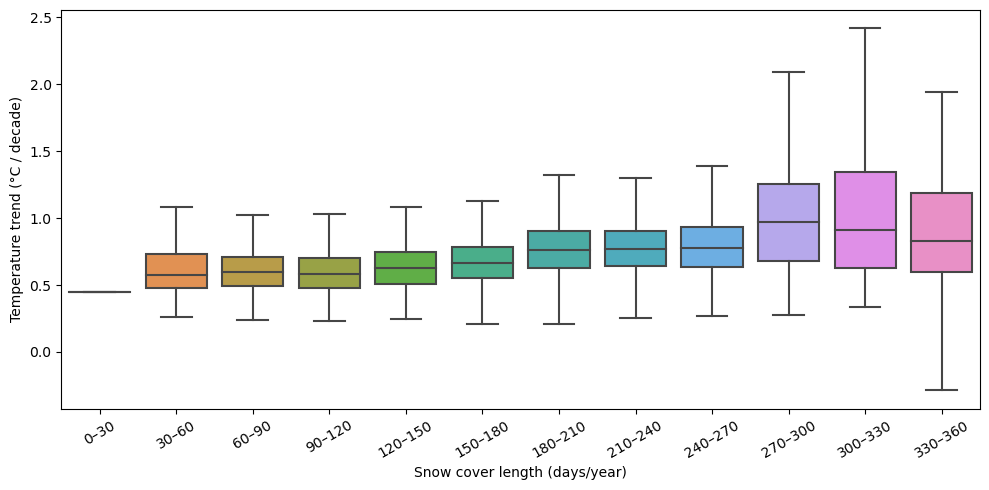

In [56]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    data=df_bin,
    x="snow_bin",
    y="trend",
    showfliers=False
)

plt.xlabel("Snow cover length (days/year)")
plt.ylabel("Temperature trend (°C / decade)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
# trends per decade in relation to warming trends


In [ ]:
# longer snow cover and higher elevation have less pronounced trends !

In [ ]:
# remove empty bin

In [57]:
snow_1d = ssl_interp.stack(points=("lat", "lon"))
lc_1d   = lc_interp['lccs_class'].stack(points=("lat", "lon"))

mask = (
    ~np.isnan(snow_1d) &
    ~np.isnan(lc_1d)
)

snow_1d = snow_1d[mask]
lc_1d   = lc_1d[mask]

In [58]:
import pandas as pd

df = pd.DataFrame({
    "snow_length": snow_1d.to_numpy(),
    "landcover": lc_1d.to_numpy().astype(int)
})

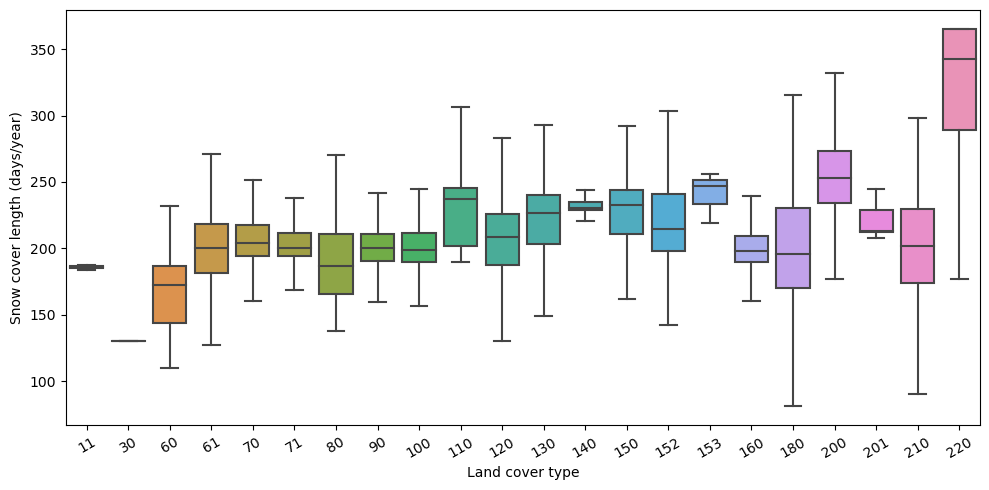

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    data=df,
    x="landcover",
    y="snow_length",
    showfliers=False
)

plt.xlabel("Land cover type")
plt.ylabel("Snow cover length (days/year)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
# just to see which classes have varrying snow cover durations!

In [ ]:
### Yamal




In [ ]:
### Greenland

